## Import Necessary Functions

These are required to utilise functions specific for data analysis and visualisations.

In [1]:
## REQUIRED LIBRARIES
# For data wrangling 
import numpy as np
import pandas as pd

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Read the Data

In [2]:

# Direct link to the CSV file on Google Drive
csv_url = 'https://drive.google.com/uc?id=14HTdhAmJd_U3mJDnwLHPbu6pvh-Yv0vu'

# Read the CSV file from the URL
data = pd.read_csv(csv_url)

data.shape


(10000, 14)

The DataFrame has 10000 rows with 14 attributes. We continue to identify what attributes will be necessary and what data manipulation needs to be carried out before Exploratory analysis and prediction modelling can be done. 


In [3]:
data.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


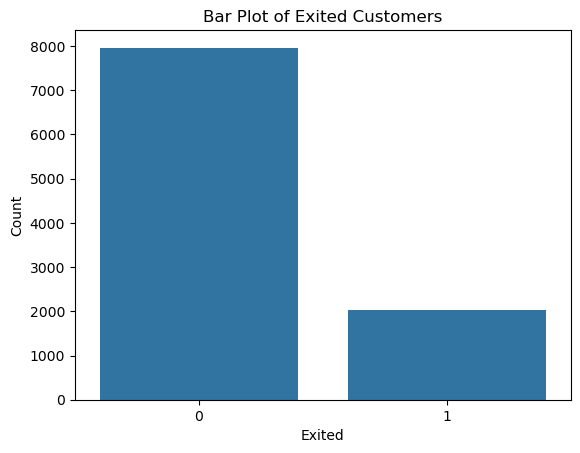

In [4]:
# Plot the distribution of the target variable
sns.countplot(data=data, x='Exited')
plt.title('Bar Plot of Exited Customers')
plt.xlabel('Exited')
plt.ylabel('Count')
plt.show()

We can see we have an imbalanced data set, with a low positive prevelance, this will impact a lot of the choices we make accross the course of this assignment.

In [5]:
# Get unique count for each variable
data.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

From the above, we will not require the first 2 attributes as these are specific to a customer. For data privacy, we remove the surname as well.

In [6]:
# Drop the columns as explained above
data = data.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

## Feature Engineering ##

We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

In [7]:
data['BalanceSalaryRatio'] = data.Balance/data.EstimatedSalary

In [8]:
data['TenureByAge'] = data.Tenure/(data.Age)

In [9]:
'''Lastly we introduce a variable to capture credit score given age to take into account credit behaviour visavis adult life
:-)'''
data['CreditScoreGivenAge'] = data.CreditScore/(data.Age)

## Prep the data for use in our models
We will do a mix of one-hot encoding and scaling of variables to ensure they are all contribute equally to our model.


## One-Hot Encoding of Categorical Variables

We will now perform one-hot encoding on the 'Geography' and 'Gender' columns using `sklearn`'s `OneHotEncoder`.

In [10]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
# Select the columns to be encoded
categorical_cols = ['Geography', 'Gender']
# Fit and transform the data
encoded_data = encoder.fit_transform(data[categorical_cols])
# Create a DataFrame with the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))
# Change to one-hot encode with -1 and 1 instead of 0 and 1
encoded_df = encoded_df.replace({0: -1})
# Concatenate the encoded columns with the original DataFrame
data = pd.concat([data.drop(categorical_cols, axis=1), encoded_df], axis=1)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095,1.0,-1.0,-1.0,1.0,-1.0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,14.829268,-1.0,-1.0,1.0,1.0,-1.0
2,502,42,8,159660.80,3,1,0,113931.57,1,1.401375,0.190476,11.952381,1.0,-1.0,-1.0,1.0,-1.0
3,699,39,1,0.00,2,0,0,93826.63,0,0.000000,0.025641,17.923077,1.0,-1.0,-1.0,1.0,-1.0
4,850,43,2,125510.82,1,1,1,79084.10,0,1.587055,0.046512,19.767442,-1.0,-1.0,1.0,1.0,-1.0


In [11]:
data[["IsActiveMember","HasCrCard","Exited"]] = data[["IsActiveMember", "HasCrCard", "Exited"]].replace({0: -1})
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,14.738095,1.0,-1.0,-1.0,1.0,-1.0
1,608,41,1,83807.86,1,-1,1,112542.58,-1,0.744677,0.024390,14.829268,-1.0,-1.0,1.0,1.0,-1.0
2,502,42,8,159660.80,3,1,-1,113931.57,1,1.401375,0.190476,11.952381,1.0,-1.0,-1.0,1.0,-1.0
3,699,39,1,0.00,2,-1,-1,93826.63,-1,0.000000,0.025641,17.923077,1.0,-1.0,-1.0,1.0,-1.0
4,850,43,2,125510.82,1,1,1,79084.10,-1,1.587055,0.046512,19.767442,-1.0,-1.0,1.0,1.0,-1.0


In [12]:
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler with feature range between -1 and 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the continuous variables
data[continuous_vars] = scaler.fit_transform(data[continuous_vars])

## Creating test and train splits

### Random 80/20

In [14]:
# Create an 80/20 train-test split with 'Exited' as the target variable
X = data.drop('Exited', axis=1)
y = data['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f"Train data shape: {X_train.shape}, Train target shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test target shape: {y_test.shape}")


Train data shape: (8000, 16), Train target shape: (8000,)
Test data shape: (2000, 16), Test target shape: (2000,)


Save the split as a dictionary and then as a pickle.

In [15]:
import pickle

# Combine all datasets into a dictionary
random_80_20 = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}

# Save the dictionary into a single pickle file
pickle.dump( random_80_20, open( "random_80_20.pickle", "wb" ) )

How to import pickle back in 

```python
# Example Python code
with open('random_80_20.pickle', 'rb') as f:
    data_random_80_20 = pickle.load(f)

X_train = data_random_80_20["X_train"]
#etc

### Random 80/20 stratified

In [16]:
X_train_strat, X_test_strat, y_train_strat, y_test_strat = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Display the shapes of the resulting datasets
print(f"Train data shape: {X_train.shape}, Train target shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test target shape: {y_test.shape}")

Train data shape: (8000, 16), Train target shape: (8000,)
Test data shape: (2000, 16), Test target shape: (2000,)


Save the split as a dictionary and then as a pickle.

In [17]:
import pickle

# Combine all datasets into a dictionary
random_80_20_strat = {
    'X_train_strat': X_train,
    'X_test_strat': X_test,
    'y_train_strat': y_train,
    'y_test_strat': y_test
}

# Save the dictionary into a single pickle file
pickle.dump( random_80_20_strat, open( "random_80_20_strat.pickle", "wb" ) )

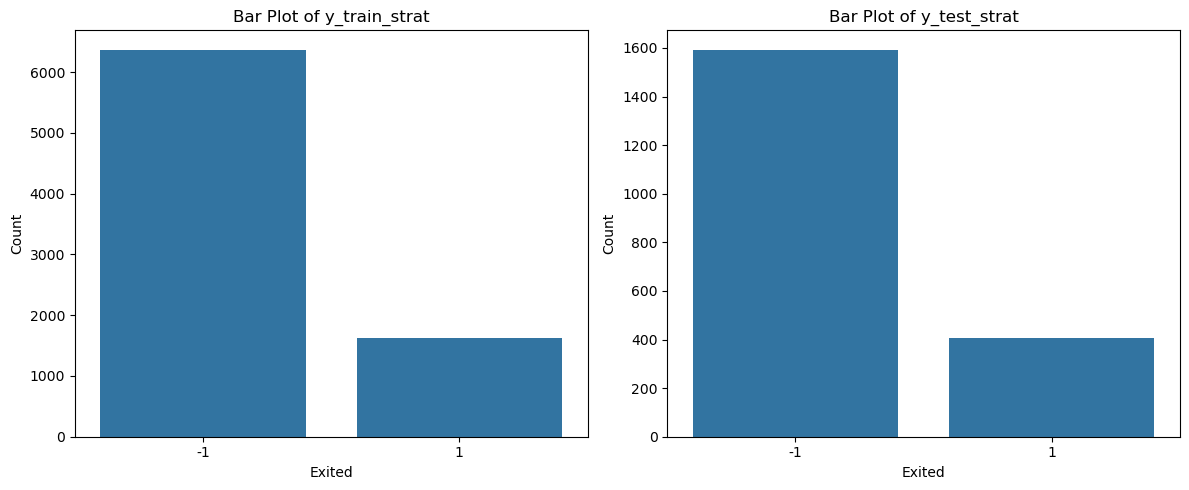

In [18]:
# Plot the distribution of y_train_strat
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train_strat)
plt.title('Bar Plot of y_train_strat')
plt.xlabel('Exited')
plt.ylabel('Count')

# Plot the distribution of y_test_strat
plt.subplot(1, 2, 2)
sns.countplot(x=y_test_strat)
plt.title('Bar Plot of y_test_strat')
plt.xlabel('Exited')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

### Under-sampled training/test split

In [19]:
!pip install imbalanced-learn

Here we use the stratified split but delete as many negative (-1) for the training set to be balanced, I left the test so though for a more realistic test for our model.

In [20]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

X_train_rus, y_train_rus = rus.fit_resample(X_train_strat, y_train_strat)
X_test_rus, y_test_rus = X_test_strat, y_test_strat 

Save the split as a dictionary and then as a pickle.

In [21]:
import pickle

# Combine all datasets into a dictionary
rus_split = {
    'X_train_rus': X_train,
    'X_test_rus': X_test,
    'y_train_rus': y_train,
    'y_test_rus': y_test
}

# Save the dictionary into a single pickle file
pickle.dump( rus_split, open( "rus_split.pickle", "wb" ) )